# `Example` Hidden Markov Model (HMM) of Investor Sentiment
This `worked example` will familiarize students with constructing and sampling Hidden Markov Models (HMMs). In particular, we will construct a three-state HMM describing the sentiment of investors consuming a news feed, e.g., analysts' reports, social media stories, etc. 

<div>
    <center>
        <img src="figs/Fig-ThreeState-ThreeAction-Markov.png" width="480"/>
    </center>
</div>

Let the states $\mathcal{S} = \left\{1,2,3\right\}$ correspond to `{optimistic, neutral, pessimistic}`. Each state $s_{j}$ in the HMM emits a unique action $a_{j}\in\mathcal{A}$, where
$\mathcal{A} = \left\{a_{1},a_{2},a_{3}\right\}$ corresponds to the `{buy, hold, sell}` actions set. The probability that the state transitions from state $s_{i}$ and $s_{j}$ in the next step is described by $p_{ij}$. Suppose we encode the sentiment of a new story into one of three categories: positive `+1`, neutral `0`, and negative `-1`, i.e., the sentiment of a story belongs to the set $\mathcal{C} = \left\{+1,0,-1\right\}$. Then, we can model
the state transition probabilities as a function of the components of a new stream of length $n$, i.e., $\left\{\mathcal{C}\right\}^{n}$ using a [Beta distribution](https://en.wikipedia.org/wiki/Beta_distribution):
* $s_{2}\rightarrow{s_{1}}$ describes the `neutral` to `optimistic` transition, encoded by the probability $p_{21}\sim\text{Beta}(\alpha,\beta)$, where $\alpha,\beta$ describes the number of positive and neutral news stories in the news feed, respectively.
* $s_{2}\rightarrow{s_{3}}$ describes the `neutral` to `pessimistic` transition, encoded by the probability $p_{23}\sim \text{Beta}(\gamma,\beta)$, where $\gamma,\beta$ describes the number of negative and neutral news stories in the news feed, respectively.
* The values for $p_{12}$ and $p_{32}$, which describe the probability of transitioning from an `optimistic` (or `pessimistic`) state to a `neutral` state, will be user-definable parameters, 
assumed to be independent of the content of the news stream.

### Tasks
* __Task 1__: Setup the Transition matrix $\mathbf{P}$, and compute the stationary distribution $\pi$
    - `TODO`: Generate a random news stream, compute the $\alpha,\beta,\gamma$ parameters, construct the transition matrix $\mathbf{P}$, and finally compute the stationary distribution $\pi$ from $\mathbf{P}$.
* __Task 2__: Setup the Emission Probability Matrix (EPM) for the sentiment HMM
    - `TODO`: Specify `EPM` and construct a dictionary of categorical distributions that represent the output signal generated from state $s_{j}$
* __Task 3__: Simulate the stationary distribution of the Hidden Markov Model (HMM)
    - `TODO`: Sample the HMM and compute the action vector for a set of investors, given the news feed generated in __Task 1__.

## Setup
Several external `Julia` packages enable the computations in this example. To load the required packages and any custom codes the teaching team has developed to work with these packages, we [include](https://docs.julialang.org/en/v1/manual/code-loading/) the `Include.jl` file):

In [1]:
include("Include.jl");

In addition to loading external packages using the `include(...)` call, we define the `iterate(...)` method, which we use to compute the stationary distribution $\pi$ recursively:
> The `iterate(P::Array{Float64,2}, counter::Int; maxcount::Int = 100, ϵ::Float64 = 0.1) -> Array{Float64,2}` function takes the transition matrix `P`, the recursion depth `counter`, the maximum recursion depth `maxcount` and a tolerance parameter `ϵ` and returns the stationary distribution $\pi$

In [2]:
function iterate(P::Array{Float64,2}, counter::Int; maxcount::Int = 100, ϵ::Float64 = 0.1)::Array{Float64,2}

    # base case -
    if (counter == maxcount)
        return P
    else
        # generate a new P -
        P_new = P^(counter+1)
        err = P_new - P;
        if (norm(err)<=ϵ)
            return P_new
        else
            # we have NOT hit the error target or the max iterations
            iterate(P_new, (counter+1), maxcount=maxcount, ϵ = ϵ)
        end
    end
end;

### Set constant values
Finally, let's define several constants that are used in the subsequent calculations:
* The number of hidden states is stored in the `number_of_hidden_states` variable, the number of observable states (emission) is stored in the `number_of_observable_states,` the number of samples is stored in the `number_of_samples` variable, the number of agents (investors) is stored in the `number_of_investors` variable and the number of steps is stored in the `number_of_simulation_steps` variable.

In [3]:
number_of_hidden_states = 3;
number_of_observable_states = 3;
number_of_samples = 1000;
number_of_investors = 10;
number_of_simulation_steps = 480;

## __Task 1__: Generate a feed, setup the transition matrix $\mathbf{P}$, and compute the stationary distribution $\pi$
Let's set up the transition matrix for our sentiment calculation. In our model, we have a `3`-states, so the Transition matrix $\mathbf{P}$ will be a `3` $\times$ `3` matrix whose entries $p_{ij}$ describe the probability that we will transition from state $i$ to state $j$ _during the next step_. 
* The values for $p_{21}$ and $p_{23}$ are functions of the number of positive $\alpha$, neutral $\beta$, and negative $\gamma$ news stories about the current asset in the investor's feed. First, let's define a function to generate a news feed that holds a particular bias using a [categorical distribution](https://en.wikipedia.org/wiki/Categorical_distribution) encoded in the [Distributions.jl package](https://github.com/JuliaStats/Distributions.jl):

In [4]:
number_of_news_stories = 100;

In [5]:
bias = [0.80,0.15,0.05];
agent_news_stream = encode(p = bias, labels=[1,0,-1], n=number_of_news_stories);

* Next, compute the number of positive, neutral, and negative news stories from the `agent_news_stream` variable by counting the labels using the `findall(...)` function in combination with the `|>` operator, i.e., the [Julia pipe operator](https://docs.julialang.org/en/v1/manual/functions/#Function-composition-and-piping) and the `length(...)` function:

In [6]:
α = findall(x->x==1,agent_news_stream) |> length
β = findall(x->x==0,agent_news_stream) |> length
γ = findall(x->x==-1,agent_news_stream) |> length
println("The agent has (α,β,γ) = ($(α),$(β),$(γ)) news stories in their feed")

The agent has (α,β,γ) = (81,13,6) news stories in their feed


* Next, let's visualize the output of $p_{21}$ and $p_{23}$ functions for different values of the fraction of positive news $\theta$, and look at how the parameters $K$ and $n$ influence the shape of the curves:

In [7]:
p21 = Beta(α,β);
p23 = Beta(γ,β);

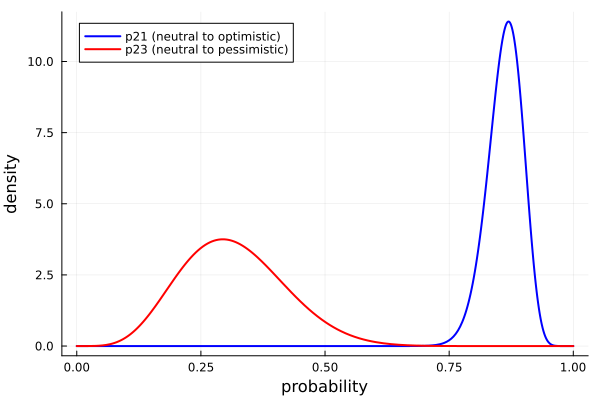

In [8]:
plot(p21, lw=2,c=:blue, label="p21 (neutral to optimistic)")
plot!(p23, lw=2,c=:red, label="p23 (neutral to pessimistic)")
xlabel!("probability", fontsize=18)
ylabel!("density", fontsize=18)

In [9]:
θ = (α/number_of_news_stories); # what is the fraction of positive stories?

* Specify the values in the transition probability matrix $\mathbf{P}$. To do this, we sample the `Beta(...)` distributions for $p_{21}$ and $p_{23}$ until we find values such that $p_{21}+p_{22}\leq{1}$, i.e., so that the $p_{22}\geq{0}$. We do this using a `while` loop, where we iterate until we find a suitable pair. For the independent probabilities, $p_{12}$ and $p_{32}$, we could randomly select values from a `Uniform` distribution, or specify another value:

In [10]:
total = Inf
p21 = nothing
p23 = nothing
while (total > 1.0)
    p21 = rand(Beta(α,β));
    p23 = rand(Beta(γ,β));
    total = p21 + p23;
end

p12 = 0.10; # select your own values
p32 = 0.10; # select your own values

* Finally, put all the entries together into the $\mathbf{P}$ matrix, and do some checks:

In [11]:
P = [
    1 - p12 p12 0.0        ; # state 1
    p21 1 - p23 - p21 p23  ; # state 2
    0.0 p32 1 - p32        ; # state 3
];

In [12]:
P

3×3 Matrix{Float64}:
 0.38132   0.61868    0.0
 0.831412  0.0318458  0.136742
 0.0       0.394866   0.605134

### `Check`: Do the rows of the transition matrix $\mathbf{P}$ sum to `1` and each value is non-negative?
The transition matrix $\mathbf{P}$ describes the probability that we transition from state $i$ (row) to state $j$ (column); thus, given that we must transition to a known future state (including the current state), the rows must sum to `1`, and each value of the probability must be `non-negative`. If the state transition matrix does not have these properties, it is `invalid.` 
* Let's develop a test to check the transition matrix validity using the `@assert` macro. We'll iterate over the rows using a `for` loop, compute the sum across the column, and compare it to `1`. In this code, we use the `|>` operator, i.e., the [Julia pipe operator](https://docs.julialang.org/en/v1/manual/functions/#Function-composition-and-piping) as a short-cut to pass the data row to the `sum` function

In [13]:
for i ∈ 1:number_of_hidden_states
    sum_value = P[i,:] |> sum;
    idx = findall(x->x<0.0, P[i,:])
    @assert((sum_value == 1) && (isempty(idx) == true))
end

### Compute the stationary distribution $\pi$

Now that we have validated the state transition matrix $\mathbf{P}$, we'll compute the stationary distribution $\pi$ using the recursive `iterate(...)` method. During each call to the `iterate(...)` method, we compute the matrix power of transition matrix $\mathbf{P}$. We continue to call the `iterate(...)` method until we hit one of two possible conditions:

* The `base case` for the recursion occurs when the `counter == maxcount`; at this point, the recursion stops, and the matrix $\mathbf{P}$ is returned
* The recursion also stops when the difference between subsequent powers of the matrix $\mathbf{P}$ is smaller than a specified threshold

In [14]:
π̄ = iterate(P,1,ϵ = 0.000001)

3×3 Matrix{Float64}:
 0.499545  0.371727  0.128729
 0.499545  0.371727  0.128729
 0.499545  0.371727  0.128729

### `Check`: is the $\pi$-distribution a $\text{rank}(\pi) = 1$ matrix?
If the `iterate(...)` function converges, it should return a `rank = ` stationary distribution matrix. Let's check this condition using the `@assert(...)` macro by calling the `rank(...)` function exported by the [LinearAlgebra.jl package](https://github.com/JuliaLang/julia/blob/master/stdlib/LinearAlgebra/src/LinearAlgebra.jl):

In [15]:
@assert(rank(π̄) == 1)

Finally, we can create a [categorical distribution](https://en.wikipedia.org/wiki/Categorical_distribution) using the stationary probability of our Markov chain using the [Distributions.jl package](https://github.com/JuliaStats/Distributions.jl), save this distribution in the variable `d`:

In [16]:
d = Categorical(π̄[1,:]);

## __Task 2__: Setup the Emission Probability Matrix (EPM)
In this model, each state emits a unique signal; thus the Emission Probability Matrix (EPM) will be the `3` $\times$ `3` identity matrix $\mathbf{I}$:

In [17]:
EPM = [
    1.0 0.0 0.0 ; # state 1
    0.0 1.0 0.0 ; # state 2
    0.0 0.0 1.0 ; # state 3
];

Populate the `emission_probability_dict,` which holds a [categorical distribution](https://en.wikipedia.org/wiki/Categorical_distribution) modeling the emission probability for each hidden state $s\in\mathcal{S}$, by building a categorical distribution for each state of the EPM.
* We used the shortcut `foreach (...)` [iteration function](https://docs.julialang.org/en/v1/base/collections/#Base.foreach) to iterate through the hidden states (iteration index `i`) and build a [categorical distribution](https://en.wikipedia.org/wiki/Categorical_distribution) distribution for each emission state.  The shortcut is equivalent to a `for-loop` over the number of hidden states.

In [18]:
emission_probability_dict = Dict{Int,Categorical}()
foreach(i -> emission_probability_dict[i] = Categorical(EPM[i,:]), 1:number_of_hidden_states);

## __Task 3__: Simulate the Hidden Markov Model (HMM)
Finally, now that we have computed (and validated) the stationary distribution and constructed the `emission_probability_dict,` we can sample our HMM model. First, we allocate storage to hold each investor's simulation in the `investor_simulation::Array{Int,2}` array. Then, we simulate the behavior of `number_of_investors` for `number_of_simulation_steps` using a nested `for` loop. For each iteration of the outer `for` loop, we select an investor and:

* We simulate `number_of_simulation_steps` sequential decisions for this investor by sampling the stationary distribution $\pi$, which tells us our hypothetical investor's internal (hidden) state at each stage. From this, we can compute the observed state (decision) by sampling the emission probability. 
* We then stote the decision of each investor `i` at step `j` in the `investor_simulation[i,j]` array

In [19]:
investor_simulation = Array{Int,2}(undef, number_of_investors, number_of_simulation_steps);
for i ∈ 1:number_of_investors
    for j ∈ 1:number_of_simulation_steps
    
        # which state is the mc in?
        hidden_state = rand(d);

        # grab the emission probability model from the emission_probability_dict -
        epd = emission_probability_dict[hidden_state];

        # role for a random ouput -
        investor_simulation[i,j] = rand(epd);
    end
end

In [20]:
investor_simulation

10×480 Matrix{Int64}:
 2  3  1  1  2  1  2  1  2  2  2  2  1  …  1  3  2  1  1  1  1  2  1  1  1  1
 2  2  1  1  3  3  3  2  1  1  1  3  2     3  2  1  1  2  2  1  1  1  2  1  1
 2  1  1  1  2  3  1  3  1  2  1  3  2     2  2  3  2  1  1  2  1  2  2  3  1
 1  1  2  1  3  1  1  2  1  2  1  1  2     1  1  3  1  1  1  1  2  1  1  2  2
 1  1  3  2  1  1  2  2  3  1  2  1  1     1  3  2  3  2  1  2  2  3  2  2  3
 1  2  3  2  1  3  1  1  1  1  1  1  2  …  1  1  2  1  3  2  3  2  2  1  1  2
 1  2  1  1  1  2  1  2  2  3  2  1  1     1  3  1  1  2  1  1  1  1  1  1  3
 2  2  2  1  1  1  1  2  1  1  1  2  1     2  3  2  2  1  1  2  1  3  2  2  1
 1  1  1  2  1  1  2  1  3  2  3  2  2     1  1  1  2  1  1  3  3  1  3  2  1
 2  1  3  2  3  2  1  3  1  2  2  3  1     1  2  2  1  1  2  2  2  2  1  1  1

In [21]:
test_value = 1;
investor_index = 4;
N₊ = 0;
for j ∈ 1:number_of_simulation_steps
    value = investor_simulation[investor_index,j];
      if (value == test_value)
        N₊ += 1
    end
end
probability = N₊/number_of_simulation_steps;
println("We observe state (decision) $(test_value) with probability = $(probability) for θ = $(100*θ)% of good news for investor = $(investor_index)")

We observe state (decision) 1 with probability = 0.5 for θ = 81.0% of good news for investor = 4


### Simulation results table

In [22]:
results_table = Array{Any,2}(undef, number_of_investors, number_of_observable_states+2);
for a ∈ 1:number_of_investors
    for i ∈ 1:number_of_observable_states
        test_value = i;
        N₊ = 0;
        for j ∈ 1:number_of_simulation_steps
            value = investor_simulation[a,j];
            if (value == test_value)
                N₊ += 1
            end
        end
        results_table[a,i+1] = (N₊/number_of_simulation_steps);
    end
    results_table[a,1] = a |> Int
    results_table[a,end] = sum(results_table[a,2:end-1])
end

In [23]:
pretty_table(results_table, header=["Agent a","P(Y=o₁|θ=$(θ))", "P(Y=o₂|θ=$(θ))", "P(Y=o₃|θ=$(θ))", "∑ P(Y=oᵢ|θ=$(θ))"])

┌─────────┬────────────────┬────────────────┬────────────────┬──────────────────┐
│ Agent a │ P(Y=o₁|θ=0.81) │ P(Y=o₂|θ=0.81) │ P(Y=o₃|θ=0.81) │ ∑ P(Y=oᵢ|θ=0.81) │
├─────────┼────────────────┼────────────────┼────────────────┼──────────────────┤
│       1 │       0.508333 │           0.35 │       0.141667 │              1.0 │
│       2 │       0.485417 │       0.379167 │       0.135417 │              1.0 │
│       3 │       0.466667 │       0.404167 │       0.129167 │              1.0 │
│       4 │            0.5 │        0.39375 │        0.10625 │              1.0 │
│       5 │         0.5125 │       0.354167 │       0.133333 │              1.0 │
│       6 │       0.460417 │       0.379167 │       0.160417 │              1.0 │
│       7 │       0.514583 │       0.360417 │          0.125 │              1.0 │
│       8 │       0.508333 │       0.379167 │         0.1125 │              1.0 │
│       9 │        0.50625 │        0.34375 │           0.15 │              1.0 │
│      10 │     

In [24]:
save(joinpath(_PATH_TO_DATA, "HMM-InvestorSentiment-Optimistic.jld2"), Dict("stationary_distribution"=>π̄, 
        "emission_probability_matrix"=>EPM))

## Disclaimer and Risks
__This content is offered solely for training and informational purposes__. No offer or solicitation to buy or sell securities or derivative products or any investment or trading advice or strategy is made, given, or endorsed by the teaching team. 

__Trading involves risk__. Carefully review your financial situation before investing in securities, futures contracts, options, or commodity interests. Past performance, whether actual or indicated by historical tests of strategies, is no guarantee of future performance or success. Trading is generally inappropriate for someone with limited resources, investment or trading experience, or a low-risk tolerance.  Only risk capital that is not required for living expenses.

__You are fully responsible for any investment or trading decisions you make__. Such decisions should be based solely on evaluating your financial circumstances, investment or trading objectives, risk tolerance, and liquidity needs.